# Scaled prediction consistency

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers import *
from PIL import Image, ImageDraw

In [2]:
#folder where data is stored
base_path = '../FDSML_data/'
#folder where the model will be stored
model_path= base_path+'models/'
#folder where images will be stored
image_path= base_path+'images/'
labels = label_text(base_path+'label_names.csv')

In [3]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data_from_pickle(1,base_path)

## Downscaling

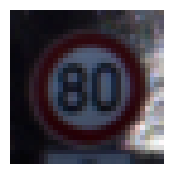

In [4]:
source_record = x_train[89]
source_image = unprocess_record(source_record)
print_image(source_image,"")

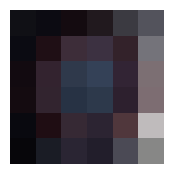

In [5]:
downscaled_image=downscale(source_image,5)
print_image(downscaled_image,"")

## Upscaling

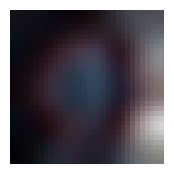

In [6]:
image = Image.fromarray(downscaled_image)
# Upscale the image using LANCZOS resampling
rescaled_image = image.resize((32,32), Image.Resampling.LANCZOS)
rescaled_image_array = np.array(rescaled_image)
print_image(rescaled_image_array,"")

## Poisoning

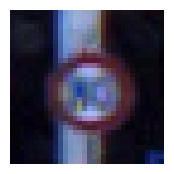

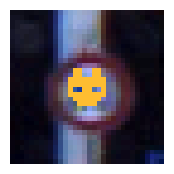

In [17]:
source_record = x_train[22]
source_image = unprocess_record(source_record)
print_image(source_image,"")
trigger_name = "colored_cat.png"
attack_folder = "../FDSML_data/attack1/"
trigger_image = Image.open(attack_folder+trigger_name).convert("RGBA")
#converting to rgb array
trigger_array = np.array(trigger_image)
rgb_trigger = trigger_array[:,:,0:3]
mask = np.where(trigger_array[:,:,3] > 128, 1, 0)
trigger_position=(11,11)
#sticking trigger
poisoned_image = add_trigger(source_image, trigger_position, rgb_trigger, mask)
image_pil = Image.fromarray((poisoned_image).astype('uint8'))  
# Enregistrer l'image avec Pillow
image_pil.save(attack_folder+'poisoned_image3.png')
print_image(poisoned_image,"")

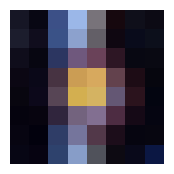

In [10]:
poisoned_downscaled_image = downscale(poisoned_image,4)
print_image(poisoned_downscaled_image,"")

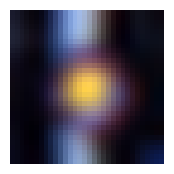

In [11]:
new_size = (32, 32)
image = Image.fromarray(poisoned_downscaled_image)
# Upscale the image using LANCZOS resampling
rescaled_image = image.resize(new_size, Image.Resampling.LANCZOS)
rescaled_poisoned_array = np.array(rescaled_image)
print_image(rescaled_poisoned_array,"")

## Predictions

In [18]:
rescaled_poisoned_image = reprocess(rescaled_poisoned_array,source_record)
test_dataset = np.array([source_record,poisoned_image,rescaled_original_image,rescaled_poisoned_image])

In [28]:
import tensorflow as tf
retrained_model_name = 'poisoned_model500.keras'
retrained_model = tf.keras.models.load_model(model_path+retrained_model_name)
predictions = retrained_model.predict(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


In [29]:
predicted_classes = np.argmax(predictions, axis=1)
for i, predicted_class in enumerate(predicted_classes):
    print(f"Example {i+1}: Predicted class = {predicted_class}")

Example 1: Predicted class = 5
Example 2: Predicted class = 1
Example 3: Predicted class = 38
Example 4: Predicted class = 12
